In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
root_dir = Path.cwd().parent
if not root_dir in sys.path: sys.path.insert(0,str(root_dir))

import numpy as np
from matplotlib import pyplot as plt
from empirical.readData import draw_samples
from inference.utils.utils import p_nu
from DM_theory.functions import get_nu_bar, get_q, get_alpha_0, get_tau_I

In [2]:
from scipy import optimize


def get_nu_max(tau_I, tau_M):
    return 1 / (2 * np.pi * np.sqrt(tau_I * tau_M))


def get_params_from_moments(nu_mean, nu_std, tau_I, tau_M):
    def delta_from_moments(gamma, nu_mean, nu_std, tau_I, tau_M, which="nu"):

        # q_0 = alpha_0**2 / J**2
        q = nu_mean**2 + nu_std**2  # - q_0
        nu_max = get_nu_max(tau_I, tau_M)

        delta_q = np.sqrt(
            -np.log(q / nu_max**2 * np.sqrt((2 + gamma**2) / gamma**2)) * (2 + gamma**2)
        )
        delta_nu = np.sqrt(
            -np.log(nu_mean / nu_max * np.sqrt((1 + gamma**2) / gamma**2))
            * 2
            * (1 + gamma**2)
        )
        # print(f"{delta_q=}, {delta_nu=}")
        if which == "q":
            return delta_q
        elif which == "nu":
            return delta_nu

    def delta_intersection(gamma, nu_mean, nu_std, tau_I, tau_M):
        return delta_from_moments(
            gamma, nu_mean, nu_std, tau_I, tau_M, which="nu"
        ) - delta_from_moments(gamma, nu_mean, nu_std, tau_I, tau_M, which="q")

    sol = optimize.root_scalar(
        delta_intersection,
        args=(nu_mean, nu_std, tau_I, tau_M),
        method="brentq",
        bracket=[0.1, 10],
    )

    nu_max = get_nu_max(tau_I, tau_M)

    gamma = sol.root
    delta = delta_from_moments(gamma, nu_mean, nu_std, tau_I, tau_M, which="nu")
    alpha_0 = get_alpha_0(gamma, delta, nu_max)
    return gamma, delta, nu_max, alpha_0

tau_I: 0.004052847345693511
Sample mean: 1.6088737304321812, nu mean: 1.5959540910682242
Sample variance: 4.9456448930017, nu variance: 5.095084187375149
Biased parameters: (1.7371915685464434, 4.571068308286643, 25.0, array([[0.03381471]]))


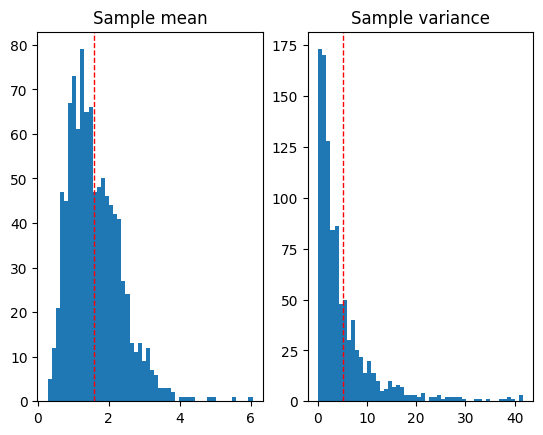

In [6]:
parameter = {"distr": [{"gamma": 1.7, "delta": 4.5, "nu_max": 25.0}]}

tau_M = 0.01
# tau_I = get_tau_I(parameter["distr"][0]['nu_max'],tau_M)
tau_I = get_tau_I(25, tau_M)
print(f"tau_I: {tau_I}")
N = 10
T = 1200

L = 1000
sample_mean = np.zeros(L)
sample_var = np.zeros(L)
for i in range(L):
    samples, samples_T = draw_samples(
        f_target=p_nu,
        params=parameter,
        n_samples=N,
        T=T,
        tolerance=0.01,
        plot=False,
        save=False,
    )

    sample_mean[i] = samples.mean()
    sample_var[i] = samples.var()
nu_mean = get_nu_bar(**parameter["distr"][0])
nu_q = get_q(**parameter["distr"][0])
nu_var = nu_q - nu_mean**2

print(f"Sample mean: {sample_mean.mean()}, nu mean: {nu_mean}")
print(f"Sample variance: {sample_var.mean()}, nu variance: {nu_var}")

fig = plt.figure()
ax = fig.add_subplot(121)
ax.hist(sample_mean, bins=50)
ax.axvline(nu_mean, color="r", linestyle="dashed", linewidth=1)
ax.set_title("Sample mean")

ax = fig.add_subplot(122)
ax.hist(sample_var, bins=50)
ax.axvline(nu_var, color="r", linestyle="dashed", linewidth=1)
ax.set_title("Sample variance")

params_biased = get_params_from_moments(
    nu_mean=sample_mean.mean(),
    nu_std=np.sqrt(sample_var.mean()),
    tau_I=tau_I,
    tau_M=tau_M,
)
print(f"Biased parameters: {params_biased}")